<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week7/template_gpt_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction in GPT features**

**GPU** is recomended for this assignment. `Runtime` -> `Change runtime type` -> `GPU`

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- Main features GPT.
- How to build generative QA based on the given data and pre-trained GPT
- Prepare own dataset and fine-tune GPT model on them.

## Add OpenAI key to Config

Before you, sign up or log in to your OpenAI account and generate an [API key](https://platform.openai.com/account/api-keys).

>**Note that while the first queries are free, there is a specific limit after which payment is required. OpenAI grants an initial budget of $18, more than enough to complete the lab, experiment with the pipeline amd fine-tune model.**

>**Please keep your API key for use during the lab review. We don't store your key, so after verifying your work and earning points, you can delete it in the API keys.**

In [ ]:
# VALIDATION_FIELD[cls] Config

class Config:

  # # Section 1
  gpt3_model_cost = 0.5/1000000
  gpt4_model_cost = 5/1000000

  # Section 2
  wiki_article_path = 'wiki_pages'

  # names of Wikipedia's articles
  article_titles = ['Kyiv', 'History of Kyiv', 'Kyiv Metro', 'Kyiv culture', 'Kyiv Music Fest', 'FC Dynamo Kyiv', 'Igor Sikorsky Kyiv Polytechnic Institute', 'Paton Bridge', 'Saint Sophia Cathedral', 'Transport in Kyiv', 'Kyiv Zoo', 'Kyiv metropolitan area', 'Taras Shevchenko National University of Kyiv', 'Euromaidan', 'Motherland Monument', 'Podil', 'Kyiv TV Tower']

  ### START CODE HERE ###
  # your OpenAI API token key
  openai_api_key = <YOUR OPENAI_API_KEY>
  ### END CODE HERE ###



## Section 1 - Try GPT

[Generative Pre-trained Transformer (GPT)](https://arxiv.org/abs/2005.14165) models by OpenAI have taken the natural language processing (NLP) community by introducing compelling language models. These models can perform various NLP tasks like question answering, textual entailment, text summarisation, Etc. Without any supervised training. These language models need very few to no examples to understand the tasks and perform equivalent to or even better than the state-of-the-art models trained in a supervised fashion.

With the recent releases of [GPT-4o](https://platform.openai.com/docs/models/gpt-4o) and other models, more powerful new versions of OpenAI’s GPT model may take much time before we can exploit their full potential.

We propose considering the possibilities of the OpenAI models they offer and how they can be applied.

First, we'll install the necessary libraries

In [ ]:
!pip install openai
!pip install wget

In [ ]:
import json
import os
import openai
from openai import OpenAI

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import csv

from collections import defaultdict
from typing import List, Dict

### **OpenAI API start**

Now, using OpenAI API, we can give a prompt to a ChatGPT. Create a [chat completions](https://platform.openai.com/docs/api-reference/chat/create) example from the [official guide](https://platform.openai.com/docs/guides/chat/introduction).

In [ ]:
# VALIDATION_FIELD[func] Client_chat_completion

### START CODE HERE ###
client = OpenAI(api_key=Config.openai_api_key)

def client_chat_completion():
  response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello!"}
    ]
  )
  return response

### END CODE HERE

test_response = client_chat_completion()
test_response

ChatCompletion(id='chatcmpl-9rOkQFX8ublRJ6Qm6W8ZwvMammITc', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', role='assistant', function_call=None, tool_calls=None))], created=1722513542, model='gpt-3.5-turbo-0125', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=9, prompt_tokens=19, total_tokens=28))

**Expected output:**

```
ChatCompletion(id='chatcmpl-9YqBk4jRNJAKlEBtqgnnjNfrrCEScca',
choices=[Choice(finish_reason='stop', index=0, logprobs=None,
message=ChatCompletionMessage(content='This is a test.',
role='assistant',
function_call=None,
tool_calls=None))],
created=1718090792,
model='gpt-3.5-turbo-0125',
object='chat.completion',
system_fingerprint=None,
usage=CompletionUsage(completion_tokens=5, prompt_tokens=12, total_tokens=17))
```
> Note: The model`s answer can be different but have the same meaning


We got the result with all the query parameters and data. The assistant’s reply in `choices[0].message.content`.

### Response Parameters:

`finish_reason` - indicates the end status of the model's output. Possible values are:

* `stop`: API returned complete model output.
* `length`: Incomplete model output due to max_tokens parameter or token limit.
* `content_filter`: Content omitted due to a flag from our content filters.
* `null`: API response still in progress or incomplete.
usage shows how many tokens the API used. This parameter is important to calculate the cost of your request. We will discuss pricing later.

Explanation of the response structure:

### ChatCompletion:

* `id`: Unique identifier for the chat session.
* `choices`: List of possible responses from the model. In this case, it contains one Choice object.
* `created`: Timestamp of when the session was created.
* `model`: Name of the model used (e.g., gpt-3.5-turbo-0125).
* `object`: Type of object (in this case, chat.completion).
* `system_fingerprint`: System fingerprint if applicable (in this case, None).
* `usage`: Information on token usage, containing:
* `completion_tokens`: Number of tokens in the model's response.
* `prompt_tokens`: Number of tokens in the initial request.
* `total_tokens`: Total number of tokens used.

### Choice:

* `finish_reason`: Reason for the model's completion.
* `index`: Index of the choice (in this case, 0).
* `message`: The message object containing:
* `content`: The content of the assistant's reply.
* `role`: The role of the message (assistant in this case).
* `function_call`: Information on any function call made by the assistant (in this case, None).
* `tool_calls`: Information on any tools called by the assistant (in this case, None).

### **Models usage examples**

We will use the `gpt-3.5-turbo`, one of the current ChatGPT model. This model is accessible on the [web interface](https://chat.openai.com). Your start budget will be enough to end this lab and more.

Using [Completions](https://platform.openai.com/docs/api-reference/completions), you can try the most available powerful model - `gpt-3.5-turbo`. Let`s ask something about Kyiv.

Create a Completion request function with the parameters:
- `max_tokens = 100`
- `temperature = 0`
- `model = "gpt-3.5-turbo"`
- `prompt is a function argument`

In [ ]:
# VALIDATION_FIELD[func] Gpt_completion

### START CODE HERE ###
def gpt_completion(prompt, temperature=0, max_tokens=100, model="gpt-3.5-turbo"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": prompt}
        ],
        max_tokens=max_tokens,
        temperature=temperature
    )
    return response
### END CODE HERE ###

Add prompt `"What is the height of the Kyiv TV tower in metres?"`

In [ ]:
# VALIDATION_FIELD[str] Kyiv_prompt

### START CODE HERE ###
kyiv_prompt = "What is the height of the Kyiv TV tower in metres?"
### END CODE HERE ###

kyiv_prompt_response = gpt_completion(kyiv_prompt)

kyiv_prompt_answer = kyiv_prompt_response.choices[0].message.content
kyiv_prompt_answer

'The height of the Kyiv TV tower is 385 meters.'

**Expected output:**

```
The height of the Kyiv TV tower is 385 meters.
```

> Note: The model`s answer can be different but have the same meaning

The correct answer has likely been obtained. Finally, you can check on the page in [Wikipedia](https://en.wikipedia.org/wiki/Kyiv_TV_Tower).

You have tried to ask a simple question that does not require analytical work. It is like a simple Google query. Let us try some math and logical questions.

* Create prompt to calculate `8 * 6 + 6`.

In [ ]:
# VALIDATION_FIELD[str] Math_prompt

### START CODE HERE ###
math_prompt = "8 * 6 + 6"
### END CODE HERE ###

math_prompt_response = gpt_completion(math_prompt)
math_prompt_answer = math_prompt_response.choices[0].message.content

math_prompt_answer

'54'

**Expected output:**

```
54
```

> Note: The model`s answer can be different but have the same meaning

GPT was able to consider and solve a simple arithmetic example. Let us use the GPT to solve the logic puzzle.

* Create prompt to solve this exercise: `Maks have five apples. Mask give two apples to Maria, after what mother give one apple more to Maks. How many apples have Maks now??`

In [ ]:
# VALIDATION_FIELD[str] Logic_prompt

### START CODE HERE ###
logic_prompt = "Maks have five apples. Mask give two apples to Maria, after what mother give one apple more to Maks. Write, how many apples have Maks now??"
### END CODE HERE ###

logic_prompt_response = gpt_completion(logic_prompt)
logic_prompt_answer = logic_prompt_response.choices[0].message.content

logic_prompt_answer

'Maks now has four apples.'

**Expected output:**

```
Maks has 4 apples now.
````

> Note: The model`s answer can be different but have the same meaning

### **Models mistakes**

GPT 3.5-turbo performed our tasks well. You could notice that the results were not immediately correct, and some prompt changes are necessary before getting the correct answer.

GPT is imperfect, so let us look at this issue in more detail.

For example, recent events. gpt-3.5-turbo is `up to June 2021` trained model, so it cannot know who is a Monarch of the United Kingdom now.

* Create prompt `Who is a monarch of the United Kingdom?`

In [ ]:
# VALIDATION_FIELD[str] Monarch_UK_prompt

### START CODE HERE ###
monarch_UK_prompt = "Who is a monarch of the United Kingdom?"
### END CODE HERE ###

monarch_UK_prompt_response = gpt_completion(monarch_UK_prompt)
monarch_UK_prompt_answer = monarch_UK_prompt_response.choices[0].message.content

monarch_UK_prompt_answer

'As of September 2021, the monarch of the United Kingdom is Queen Elizabeth II.'

**Expected output:**

```
As of September 2021, the monarch of the United Kingdom is Queen Elizabeth II.
```

> Note: The model`s answer can be different but have the same meaning

We got the wrong answer, and you can check it on [Wikipedia page](https://en.wikipedia.org/wiki/Monarchy_of_the_United_Kingdom) (Charles III has been the monarch since 8 September 2022).

Let's test the mathematical abilities of the model and try a more complex exercise.

* Use your previous math prompt to solve `sqrt(1213*4345)`

In [ ]:
# VALIDATION_FIELD[str] Harder_math_prompt

### START CODE HERE ###
harder_math_prompt = "sqrt(1213*4345)"
### END CODE HERE ###

harder_math_prompt_response = gpt_completion(harder_math_prompt)
harder_math_prompt_answer = harder_math_prompt_response.choices[0].message.content

harder_math_prompt_answer

'sqrt(1213*4345) ≈ sqrt(5271985) ≈ 2295.76'

**Expected output:**

```
Anything except 2295.75
```

GPT models are a powerful tool. As we have seen, he can also make mistakes and answer incorrectly to complex and simple questions (try to solve the simple exercise `8*6 + 6*8`).


### **Generate haiku**


However, models can understand what you ask, act according to the limits of the user's words, and even come up with something of your own.

Let us generate a [Haiku](https://www.britannica.com/art/haiku) about ChatGPT using the `Gpt-3.5-turbo` model as the fastest text model.

Create a Completion request with next parameters:
- `max_tokens = 120`
- `temperature = 0.3`
- `model = "gpt-3.5-turbo"`
- `"Tell me a Haiku about ChatGPT"`

In [ ]:
# VALIDATION_FIELD[str] Gpt3_haiku

### START CODE HERE ###
gpt3_haiku_prompt = "Tell me a Haiku about ChatGPT"
haiku_gpt3_response = gpt_completion(gpt3_haiku_prompt, max_tokens = 120, temperature = 0.3, model = "gpt-3.5-turbo")
### END CODE HERE ###

haiku_gpt3_answer = haiku_gpt3_response.choices[0].message.content
print(haiku_gpt3_answer)

ChatGPT, so wise
Words flow like a gentle stream
AI friend, so kind


Let's compare with `gpt-4-turbo` model as the bigger model.

Create a Completion request with next parameters:
- `max_tokens = 120`
- `temperature = 0.3`
- `model = "gpt-4-turbo"`
- `"Tell me a Haiku about ChatGPT"`

In [ ]:
# VALIDATION_FIELD[str] Gpt4_haiku

### START CODE HERE ###
gpt4_haiku_prompt = "Tell me a Haiku about ChatGPT"
haiku_gpt4_response = gpt_completion(gpt4_haiku_prompt, max_tokens = 120, temperature = 0.3, model = "gpt-4-turbo")
### END CODE HERE ###

haiku_gpt4_answer = haiku_gpt4_response.choices[0].message.content
print(haiku_gpt4_answer)

Whispers of circuits,
ChatGPT spins tales and wisdom,
Silent mind awakes.


Now we can compare both answers

In [ ]:
print('GPT 3.5 turbo model haiku:')
print(haiku_gpt3_response.choices[0].message.content)
print('------------------------------------')
print('GPT 4 turbo model haiku:')
print(haiku_gpt4_response.choices[0].message.content)
print('------------------------------------')
print('GPT 3.5 cost: %.8f $' % (Config.gpt3_model_cost * haiku_gpt3_response.usage.total_tokens))
print('GPT 4 cost: %.8f $' % (Config.gpt4_model_cost * haiku_gpt4_response.usage.total_tokens))

GPT 3.5 turbo model haiku:
ChatGPT, so wise
Words flow like a gentle stream
AI friend, so kind
------------------------------------
GPT 4 turbo model haiku:
Whispers of circuits,
ChatGPT spins tales and wisdom,
Silent mind awakes.
------------------------------------
GPT 3.5 cost: 0.00001750 $
GPT 4 cost: 0.00017500 $


As you can see, the GPT-4 model creates more creative and better haiku than GPT-3.5. However, using GPT-4o is more expensive than GPT-3.5, following this table:

<table>
  <tr>
    <td>gpt-3.5-turbo:</td>
    <td> $0.00001550</td>
  </tr>
  <tr>
    <td>gpt-4o:</td>
    <td> $0.00017400</td>
  </tr>
</table>

We need to pay more for better results. You can learn more about OpenAI pricing on the [official website](https://openai.com/pricing).

### **Creative solution**

GPT is a powerful multitasking model that can solve many different tasks. You can ask any question, how who is the Great Britan monarch or information about a favorite character, and solve math and logic tasks. However, the capabilities of the models are wider than this.

Using GPT, we can solve more complex tasks, and let's try to do something.

### **GraphGPT**

The main idea is to create a prompt that will allow us to convert unstructured natural language into a knowledge graph.

To do this, we need to create a prompt from our task and provide the GPT recording formats and an example of execution.


You need fill `//-- add your text here --//` in the following prompt:
> * Describe the task of finding as many connections as possible and writing them down in a list.
* Note that the single format `[ENTITY 1, RELATIONSHIP, ENTITY 2]` should be used, relations are directed, and the order is important.
* For testing, use `Maks, Petro and Vlad are colleagues.`

In [ ]:
# VALIDATION_FIELD[str] Graph_prompt

### START CODE HERE ###
#graph_prompt ="""Find as many connections as possible between the entities in the following text 'Maks, Petro, and Vlad are colleagues' and write them down in a nested array. Use the following format: [["ENTITY 1", "RELATIONSHIP", "ENTITY 2"]]. Remember that relationships are directed, and the order is important."""
                #For example, if the text says 'Maks, Petro, and Vlad are colleagues',"""# you would write:
    # [["Maks", "colleague", "Petro"],\
    #  ["Maks", "colleague", "Vlad"],\
    #  ["Petro", "colleague", "Maks"],\
    #  ["Petro", "colleague", "Vlad"],\
    #  ["Vlad", "colleague", "Maks"],\
    #  ["Vlad", "colleague", "Petro"]]\
    # Now, apply this to the following text: Maks, Petro and Vlad are colleagues."""
# "Find as many connections as possible between the entities in the following text 'Maks, Petro and Vlad are colleagues'. and write them down in a square brackets as a nested list. Use the following format: [[ENTITY 1, RELATIONSHIP, ENTITY 2]]"

graph_prompt = """Given a prompt, Maks, Petro and Vlad are colleagues..

If an update is a relationship, add the relationship in the form of a list of lists. Each sublist contains the first person, the relationship, and the second person..

Example:
prompt: Alice is Bob's roommate.
updates:
[["Alice", "roommate", "Bob"]]

prompt:  Maks, Petro and Vlad are colleagues.
updates:
"""
### END CODE HERE ###

graph_prompt_response = gpt_completion(graph_prompt)
graph_prompt_answer = graph_prompt_response.choices[0].message.content

print(graph_prompt_answer)

[["Maks", "colleague", "Petro"], ["Maks", "colleague", "Vlad"], ["Petro", "colleague", "Maks"], ["Petro", "colleague", "Vlad"], ["Vlad", "colleague", "Maks"], ["Vlad", "colleague", "Petro"]]


Expected output:
```
    [["Maks", "colleague", "Petro"],
     ["Maks", "colleague", "Vlad"],
     ["Petro", "colleague", "Maks"],
     ["Petro", "colleague", "Vlad"],
     ["Vlad", "colleague", "Maks"],
     ["Vlad", "colleague", "Petro"]]
```



Create functions using [networkx](https://networkx.org/documentation/stable/reference/introduction.html) for visualizing the obtained connections:

In [ ]:
# VALIDATION_FIELD[str] create_show_graph

def create_relationships_dataframe(answer_data):
    # Answer data is a string, we need to extract the JSON part
    json_start = answer_data.find('[')
    json_end = answer_data.rfind(']') + 1
    json_data = answer_data[json_start:json_end]

    # Close JSON array if it's incomplete
    if answer_data.count('[') > answer_data.count(']'):
        json_data += ']]'

    # Parse the JSON data
    relationships = json.loads(json_data)
    from_label = [relationship[0] for relationship in relationships]
    weight_label = [relationship[1] for relationship in relationships]
    to_label = [relationship[2] for relationship in relationships]

    # Create a DataFrame
    df_relationships = pd.DataFrame({'from': from_label, 'to': to_label, 'weight': weight_label})
    return df_relationships

def get_connection_relationship_weight(edge, df_relation):
    name = df_relation.loc[(df_relation['from'] == edge[0]) & (df_relation['to'] == edge[1])]['weight'].iloc[0]
    return name

def show_graph(answer_data):
    if isinstance(answer_data, list):
        relationships = answer_data
    else:
        print("Unsupported data format")
        return

    from_label = [relationship[0] for relationship in relationships]
    weight_label = [relationship[1] for relationship in relationships]
    to_label = [relationship[2] for relationship in relationships]
    df_relationships = pd.DataFrame({'from': from_label, 'to': to_label, 'weight': weight_label})

    G = nx.from_pandas_edgelist(df_relationships, 'from', 'to', create_using=nx.DiGraph())

    pos = nx.spring_layout(G)

    nx.draw(G, pos, with_labels=True, node_size=800, node_color="lightblue")

    labels = {e: df_relationships.loc[(df_relationships['from'] == e[0]) & (df_relationships['to'] == e[1])]['weight'].iloc[0] for e in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # show graph
    plt.show()

Now you can visualize your graph.

[['Maks', 'colleague', 'Petro'], ['Maks', 'colleague', 'Vlad'], ['Petro', 'colleague', 'Maks'], ['Petro', 'colleague', 'Vlad'], ['Vlad', 'colleague', 'Maks'], ['Vlad', 'colleague', 'Petro']]


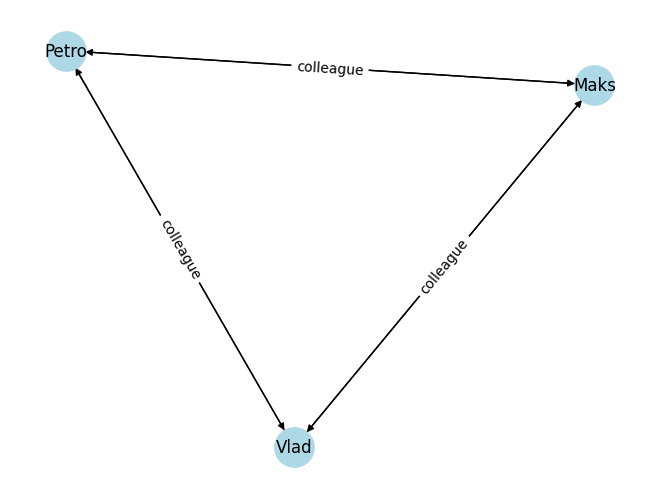

In [ ]:
data = json.loads(graph_prompt_answer)
print(data)
show_graph(data)

The graph you obtained show the relationship between Peter, Vlad and Max, as specified in your prompt. All of them are colleagues and related to each other.

To make sure that the prompt you created works correctly, let us consider a more complex condition by adding external relations


You need fill `//-- add your text here --//` in the following prompt:
> * Paste your description and formatting.
* Generate next relationships graph: `Markus, Mario, Clara and Mykyta are friends. Maria is Clara teacher and Markus mother and Sam lives with Mario.`

In [ ]:
# VALIDATION_FIELD[str] Harder_graph_prompt

### START CODE HERE ###
harder_graph_prompt = """Given a prompt, Markus, Mario, Clara and Mykyta are friends. Maria is Clara's teacher and Markus's mother and Sam lives with Mario..

If an update is a relationship, add the relationship in the form of a list of lists. Each sublist contains the first person, the relationship, and the second person.

Example:
prompt: Alice is Bob's roommate.
updates:
[["Alice", "roommate", "Bob"]]

prompt: Markus, Mario, Clara and Mykyta are friends. Maria is Clara's teacher and Markus's mother and Sam lives with Mario.
updates:
"""

### END CODE HERE ###

harder_graph_prompt_response = gpt_completion(harder_graph_prompt, max_tokens=600)
harder_graph_prompt_answer = harder_graph_prompt_response.choices[0].message.content

print(harder_graph_prompt_answer)

[["Markus", "friend", "Mario"],
 ["Markus", "friend", "Clara"],
 ["Markus", "friend", "Mykyta"],
 ["Mario", "friend", "Markus"],
 ["Mario", "friend", "Clara"],
 ["Mario", "friend", "Mykyta"],
 ["Clara", "friend", "Markus"],
 ["Clara", "friend", "Mario"],
 ["Clara", "friend", "Mykyta"],
 ["Mykyta", "friend", "Markus"],
 ["Mykyta", "friend", "Mario"],
 ["Mykyta", "friend", "Clara"],
 ["Maria", "teacher", "Clara"],
 ["Maria", "mother", "Markus"],
 ["Sam", "roommate", "Mario"]]


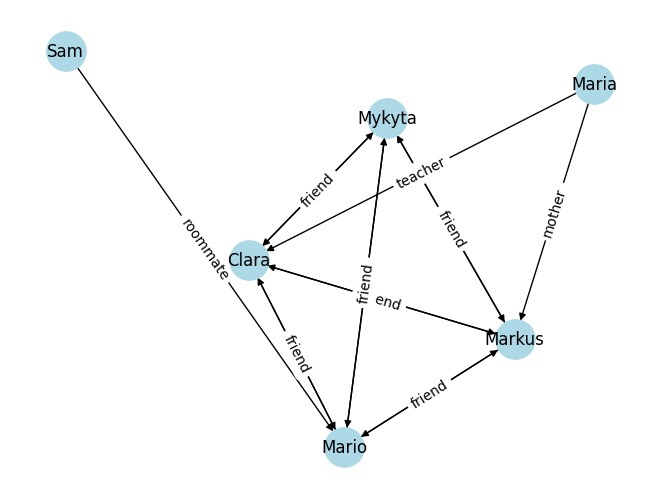

In [ ]:
result = json.loads(harder_graph_prompt_answer)
show_graph(result)

Expected output:
```
[['Markus', 'friend', 'Mario'],
 ['Markus', 'friend', 'Clara'],
 ['Markus', 'mother', 'Maria'],
 ['Mario', 'friend', 'Markus'],
 ['Mario', 'friend', 'Clara'],
 ['Mario', 'friend', 'Mykyta'],
 ['Clara', 'friend', 'Markus'],
 ['Clara', 'friend', 'Mario'],
 ['Clara', 'teacher', 'Maria'],
 ['Mykyta', 'friend', 'Mario'],
 ['Maria', 'teacher', 'Clara'],
 ['Maria', 'mother', 'Markus'],
 ['Sam', 'lives with', 'Mario']]
 ```

> Note: The model`s answer can be different but have the same meaning


## **Section 2 - Search Engine with GPT-3**

[Haystack](https://haystack.deepset.ai) is an open-source framework for building search systems that work intelligently over large document collections. Besides providing a comfortable entry point to the [OpenAI API](https://openai.com/product), Haystack offers all the other components we need to successfully implement an end-to-end NLP system with GPT: a vector database, a module for retrieval, and the pipeline that combines all those elements into one queryable system.
In this lab, we’ll demonstrate how to build a generative question-answering system that uses the `gpt-3.5-turbo` model to present results in convincing natural language.


In [ ]:
# Install necessary library
!pip install --upgrade farm-haystack[all]

In [ ]:
from haystack.nodes import PreProcessor
from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import EmbeddingRetriever
from haystack.nodes import PromptNode
from haystack import Pipeline

### **Build a Search Engine with GPT-3**

If you’ve been online lately, you’ve likely seen the excitement about OpenAI’s newest language model, ChatGPT. ChatGPT is astonishingly good at many things, including debugging code and rewriting text in whatever style you ask it. As an offshoot of GPT-3.5, a large language model (LLM) with billions of parameters, ChatGPT owes its impressive knowledge to the fact that it’s seen a large portion of the internet during training — in the form of the Common Crawl corpus and other data.

Chatbots are understandable that people are excited by a language model that can hold a conversation and create a solid semblance of intelligence. But we need to stay critical when it comes to the validity of answers generated by these models. LLMs especially are prone to hallucinations: producing text that sounds sensible at first but doesn’t hold up to closer scrutiny and presenting things as facts that are made up entirely.
Semantic search engines — our specialty at deepset — are often powered by extractive question-answering models. These models return verbatim snippets from the knowledge base rather than generating text from scratch the way ChatGPT does.

[Haystack](https://docs.haystack.deepset.ai/docs/intro), deepset’s open-source framework for applied natural language processing (NLP), allows you to leverage multiple GPT models in your pipeline. With this approach, you can build a GPT-powered semantic search engine that uses your data as ground truth and bases its natural-language answers on the information it contains. Besides providing a comfortable entry point to the OpenAI API, Haystack offers all the other components you need to successfully implement an end-to-end NLP system with GPT: a vector database, a module for retrieval, and the pipeline that combines all those elements into one queryable system.

### **The advent of large language models**

But while the largest BERT model has 336 million parameters, OpenAI’s largest GPT-3.5 model — which ChatGPT is based on — has 520 times as many.

From observation, we can say that GPT is exceptionally good at understanding implication and intent. It can remember what’s been discussed earlier in the conversation, including figuring out what you’re referring to with words like “he” or “before that,” It can tell you when your question doesn’t make sense. All of these properties account for the increased importance of actual intelligence. It also has to generate language from scratch, a much more challenging task than returning the correct section from a corpus.

### **Different types of search engines**

Semantic search engines come in different varieties and can roughly be distinguished by the type of answer they return. The answers could consist of matching documents (in document search), answer spans (in extractive QA), or newly generated answers (in generative QA).

### **The GenerativeQAPipeline: Haystack’s component for a generative search engine**

In this lab, we use the GenerativeQAPipeline. It consists of a retriever (to find relevant documents) and a generator (to write the text) chained together. The retriever connects to the database. Like the generator, it is often (but not necessarily) based on a Transformer model. Its task is to retrieve the documents from the database that are most likely to contain valuable information based on a user’s input query.

In [ ]:
# VALIDATION_FIELD[str] Download_articles
# Download artices from Wikipedia

import wget
import zipfile

wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/datasets/07_attention_transformers/GPT-3/wikipedia_articles.zip')
with zipfile.ZipFile("wikipedia_articles.zip","r") as zip_ref:
    zip_ref.extractall("")

>**Task**:
* Open the file in read mode with UTF-8 encoding and read its content
* Create a document dictionary with 'content' and 'meta' keys
* Append the document dictionary with 'content' and 'meta' keys



In [ ]:
# VALIDATION_FIELD[func] Read_documents

# init files/articles
wiki_files_path = Config.wiki_article_path
article_titles = Config.article_titles

def read_documents(folder_path, article_titles):
    docs = []
    for title in article_titles:
        #print(title)
        file_path = os.path.join(folder_path, f"{title}.txt")
        ### START CODE HERE ###
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            doc = {'content': content, 'meta': {'title': title}}
            docs.append(doc)
        ### END CODE HERE ###
    return docs

docs = read_documents(wiki_files_path, article_titles)
# for doc in docs:
#   print(doc)

#### Preprocessing Documents

Use the PreProcessor from the Haystack library to split and clean the documents.

> **Task:**
> 1. Initialize FAISS Document Store:
  - A FAISS Document Store is already initialized with a `Flat index factory string`.
2. Initialize PreProcessor with the following parameters:
  - `clean_empty_lines`: Removes empty lines from the documents.
  - `clean_whitespace`: Cleans up extra whitespace.
  - `clean_header_footer`: Removes headers and footers.
  - `split_by`: Splits documents by words.
  - `split_length`: Each split should have a length of 200 words.
  - `split_respect_sentence_boundary`: Ensures splits respect sentence boundaries.
3. Process Documents:
  - Use the initialized `PreProcessor` to process the docs variable (a list of documents).
4. Write Documents to FAISS Document Store:
  - Write the processed documents to the FAISS Document Store.




In [ ]:
# VALIDATION_FIELD[str] Preprocessing_documents

### START CODE HERE ###
# Initialize FAISS Document Store
document_store = FAISSDocumentStore()

# Initialize PreProcessor
preprocessor = PreProcessor(clean_empty_lines=True,
                            clean_whitespace=True,
                            clean_header_footer=True,
                            split_by='word',
                            split_length=200,
                            split_respect_sentence_boundary=True)

# Process documents
processed_docs = preprocessor.process(docs)
# Write documents
document_store.write_documents(processed_docs)
### END CODE HERE ###

print("\nDocuments have been successfully preprocessed and stored.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Preprocessing: 100%|██████████| 17/17 [00:00<00:00, 17.38docs/s]
Writing Documents: 10000it [00:02, 4733.13it/s]


Documents have been successfully preprocessed and stored.


#### Initializing the Document Store

> **Task:**
>
> 1. Set Embedding Dimension:
  - Set the embedding_dim to `1536` as per the model requirements.
> 2. Remove Existing FAISS Document Store:
>  - If a file named `faiss_document_store.db exists, remove it` to ensure a fresh start.
3. Initialize FAISS Document Store:
  - Initialize the FAISS Document Store with the `Flat index factory string` and `the specified embedding dimension`.


In [ ]:
# VALIDATION_FIELD[str]: Initializing_document_store

### START CODE HERE ###
# Set embedding dimension according to the model
embedding_dim = 1536

# Remove existing FAISS document store if exists
if os.path.exists("faiss_document_store.db"):
  os.remove("faiss_document_store.db")


# Initialize FAISS Document Store with specified embedding dimension
document_store = FAISSDocumentStore(faiss_index_factory_str='Flat', embedding_dim=embedding_dim)
### END CODE HERE ###

#### Deleting Existing Documents and Adding New Ones

Delete any existing documents in the database and add the preprocessed documents.

In [ ]:
# VALIDATION_FIELD[str] Rewrite_preprocessed_documents

document_store.delete_documents()
document_store.write_documents(processed_docs)

Writing Documents: 10000it [00:00, 12476.84it/s]


#### Setting Up the Retriever

>**Task:**
>
> Initialize the `EmbeddingRetriever` with the following parameters:
 - `document_store`: The FAISS Document Store instance.
 - `embedding_model`: Set to `"text-embedding-ada-002"`.
 - `api_key`: The OpenAI API key from the Config class.
 - `batch_size`: Set to 32.
 - `max_seq_len`: Set to 2048.

In [ ]:
# VALIDATION_FIELD[str] Initialize_retriewer

# Initialize Retriever with OpenAI's embedding model
### START CODE HERE ###
retriever = EmbeddingRetriever(document_store=document_store,
                               embedding_model="text-embedding-ada-002",
                               api_key=Config.openai_api_key,
                               batch_size=32,
                               max_seq_len=2048)
### END CODE HERE ###

# Update embeddings in the document store
document_store.update_embeddings(retriever)


Calculating embeddings: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]
Documents Processed: 10000 docs [00:05, 1874.08 docs/s]


#### Setting Up the Generator

You are given a partially implemented script that initializes a PromptNode for text generation using OpenAI's GPT-4 model. Your task is to complete the script by initializing the PromptNode with the model name and API key. Follow the instructions below:

> **Task:**
> - Use the `PromptNode` class from haystack.nodes.
> - Set the model name to `"gpt-4"`.
> - Retrieve the OpenAI API key from the Config class (`Config.openai_api_key)`

In [ ]:
# VALIDATION_FIELD[str] Initialize_generator

# Initialize Generator with GPT-4 model
### START CODE HERE ###
generator = PromptNode(model_name_or_path="gpt-4", api_key=Config.openai_api_key)
### END CODE HERE ###

#### Create a Custom Pipeline:

> **Task:**
> Use the `Pipeline` class from the haystack module to create a new pipeline instance.
> 1. Add the retriever node to the pipeline:
  - Set the `component` to the `retriever` instance.
  - Set the name to `"Retriever"`.
  - Set the inputs to `["Query"]`.
2. Add the generator node to the pipeline:
  - Set the `component` to the `generator` instance.
  - Set the name to `"Generator"`.
  - Set the inputs to `["Retriever"]`.

In [ ]:
# VALIDATION_FIELD[str] Create_pipeline

# Create a custom pipeline and add the retriever and generator nodes
### START CODE HERE ###
pipeline = Pipeline()
pipeline.add_node(component=retriever, name="Retriever", inputs=["Query"])
pipeline.add_node(component=generator, name="Generator", inputs=["Retriever"])
### END CODE HERE ###

In [ ]:
pipeline.components

{'FAISSDocumentStore': <haystack.document_stores.faiss.FAISSDocumentStore at 0x7981336f27d0>,
 'Generator': <haystack.nodes.prompt.prompt_node.PromptNode at 0x7981324842e0>,
 'Retriever': <haystack.nodes.retriever.dense.EmbeddingRetriever at 0x798132497370>}

Expected output:

```
{'Generator': <haystack.nodes.prompt.prompt_node.PromptNode at 0x0000>,
 'FAISSDocumentStore': <haystack.document_stores.faiss.FAISSDocumentStore at 0x0000>,
 'Retriever': <haystack.nodes.retriever.dense.EmbeddingRetriever at 0x0000>}
```

In [ ]:
# Pass retriever results to generator and set max_tokens for longer completions
query = 'Where is located Kyiv zoo?'
generator_results = generator.prompt(query, documents=retriever, max_tokens=100)
#print(generator_results)
# If generator_results is a list of strings, create dictionaries with empty contexts
formatted_results = [{"answer": query, "context": result} for result in generator_results]
print(formatted_results)

[{'answer': 'Where is located Kyiv zoo?', 'context': 'Kyiv Zoo is located in Kyiv, the capital of Ukraine. The exact address is Peremohy Ave, 32, Kyiv, Ukraine, 04116.'}]


Expected result:

```
[{'answer': 'Where is located Kyiv zoo?',
'context': 'Kyiv Zoo is located in Kyiv, the capital of Ukraine.
The exact address is: Academician Bohdan Khmelnytsky Street, 1, Kyiv, Ukraine, 04060.'}]
```
> Note: The answer can be different but have the same meaning


> **Task:** Implement a Function to Query the User Pipeline. Follow the instructions below:
1. Perform Retrieval:
  - Use the `retriever` instance to `retrieve` relevant documents based on the query.
  - Set top_k to `the top_k_retriever` parameter (default is 5).
2. Pass Retrieval Results to Generator:
  - Use the `generator` instance to `prompt` a response based on the query and the retrieved documents.
  - Set the max_tokens to the `max_tokens` parameter (default is 1000).

In [ ]:
# VALIDATION_FIELD[func] Query_pipeline

# Function to query the user pipeline and print the answer

### START CODE HERE ###
def query_pipeline(query, top_k_retriever=5, max_tokens=1000):
    # Performing retrieval
    retriever_results = retriever.retrieve(query=query, top_k=top_k_retriever)
    #print(f'Retriever Result: {retriever_results}')
    res = ''.join([i.content for i in retriever_results])
    #print(res)


    # Passing retrieval results to the generator and setting max_tokens for longer completions
    generator_results = generator.prompt(query, documents=res, max_tokens=100)
  ### END CODE HERE ###

    # Checking if generator_results is empty
    if not generator_results:
        print("No answers found.")
        return

    # Print answers
    print(generator_results)


In [ ]:
# VALIDATION_FIELD[str] Query_pipeline_first

query_pipeline_first = query_pipeline("What is Kyiv known for?")
print(query_pipeline_first)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


["Kyiv, the capital of Ukraine, is known for its religious architecture, historical monuments, and rich cultural history. Among its most famous landmarks are the Kyiv Pechersk Lavra (Caves Monastery), a UNESCO World Heritage Site, and St. Sophia's Cathedral, one of the city's best known symbols. Kyiv is also known for its role in the arts with many galleries, theatres and music events. Furthermore, it is home to several major universities and scientific institutions."]
None


Expected result:
```
["Kyiv, the capital of Ukraine, is known for its rich history, beautiful architecture ..."]
```
> Note: The answer can be different but have the same meaning



In [ ]:
# VALIDATION_FIELD[str] Query_pipeline_second

query_pipeline_second = query_pipeline("When is the best time to visit Kyiv?")
print(query_pipeline_second)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


['The best time to visit Kyiv is during the late spring (May to June) and early fall (September to October) when the weather is mild and the city is less crowded with tourists. During these months, you can enjoy outdoor activities and sightseeing. The city is particularly beautiful in May when many flowers are in bloom.']
None


Expected result:
```
['The best time to visit Kyiv, Ukraine is during late spring (April to June) and early autumn ...']
```
> Note: The answer can be different but have the same meaning

In [ ]:
# VALIDATION_FIELD[str] Query_pipeline_third

query_pipeline_third = query_pipeline("Do people from Kyiv have their own culture?")
print(query_pipeline_third)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


['Yes, people from Kyiv, the capital city of Ukraine, have their own distinct culture. This culture is a blend of both traditional Ukrainian elements and influences from other cultures, making it quite unique. It is characterized by a rich history, distinctive architecture, traditional music and dances, a love for arts and literature, and a vibrant food scene. Kyiv is also known for its cultural events, festivals, and a deep appreciation for its historical heritage. From their language, which is predominantly Ukrainian, to']
None


Expected result:

```
['Yes, people from Kyiv, the capital city of Ukraine, have their own distinctive culture. ...']
```
> Note: The answer can be different but have the same meaning

In [ ]:
# VALIDATION_FIELD[str] Query_pipeline_four

query_pipeline_four = query_pipeline("Tell me about some interesting places in Kyiv")
print(query_pipeline_four)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


['1. Kyiv Pechersk Lavra: Also known as the Kyiv Monastery of the Caves, it is a historic Orthodox Christian monastery that has been a preeminent center of Eastern Orthodox Christianity in Eastern Europe.\n\n2. Maidan Nezalezhnosti (Independence Square): This is the central square of Kyiv, the capital city of Ukraine. It has been the site of many political events, including the 2004 Orange Revolution and the 2013-14']
None


Expected result:

```
['1. Kyiv Pechersk Lavra: Also known as the Monastery of the Caves ...']
```
> Note: The answer can be different but have the same meaning

In [ ]:
# VALIDATION_FIELD[str] Query_pipeline_five

query_pipeline_five = query_pipeline("How was the TV tower built?")
print(query_pipeline_five)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


["The construction process of a TV tower varies depending on its design and specifications. However, here's a general outline of how most TV towers are built:\n\n1. Planning and Design: This involves creating a detailed blueprint of the tower, which includes its height, base width, antenna specifications, and more. Engineers also have to consider local weather conditions, earthquake risks, and wind speeds.\n\n2. Site Preparation: The construction site is cleared of any obstacles and leveled. Soil testing is conducted to ensure it can"]
None


Expected result:

```
['The construction process of a TV tower can vary depending on the specific ...']
```
> Note: The answer can be different but have the same meaning

In [ ]:
# VALIDATION_FIELD[str] Query_pipeline_six

query_pipeline_six = query_pipeline("Is Kyiv a good place for clubbing?")
print(query_pipeline_six)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


["Yes, Kyiv is known for its vibrant nightlife with a wide selection of clubs that cater to different tastes in music and atmosphere. Some of the popular clubs in Kyiv include Closer, Skybar, and D.Fleur. The city hosts many international DJs and events. However, as with any city, it's always important to be aware of your surroundings and stay safe while enjoying the nightlife."]
None


Expected result:

```
['Yes, Kyiv is known for its vibrant nightlife and is indeed a good place for clubbing ...']
```
> Note: The answer can be different but have the same meaning

## **Section 3 - Fine-tune GPT**

Fine-tuning is the process of training a [Large Language Model (LLM)](https://en.wikipedia.org/wiki/Large_language_model) to recognize a specific pattern of input and output that can be applied to any custom NLP task.

Taken from the [official docs](https://platform.openai.com/docs/guides/fine-tuning), fine-tuning lets you get more out of the GPT-3 models by providing the following:
* Higher quality results than prompt design
* Ability to train on more examples than can fit in a * prompt
* Token savings due to shorter prompts
* Lower latency requests

Fine-tuning involves the following steps:
* Prepare and upload training data
* Train a new fine-tuned model
* Use your fine-tuned model

In [ ]:
# VALIDATION_FIELD[str] Download_dataset
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/datasets/07_attention_transformers/GPT-3/QA_DataRoot_Labs.csv')

'QA_DataRoot_Labs (1).csv'

In [ ]:
data = pd.read_csv('QA_DataRoot_Labs.csv')

print('Prompt:', data.iloc[0]['prompt'])
print('Completion:', data.iloc[0]['completion'])

Prompt: What is it DataRoot Labs?
Completion:  DataRoot Labs is a full-service Data Science & Artificial Intelligence R&D company with main focus on Big Data Management & Strategy Consulting, Data Science & Engineering.DataRoot Labs consists of AI, HighLoad and Science teams — geeks, really good at building & assembling AI-Enabled solutions & Infrastructures, complex scientific R&D.AI Lab delivers to our partners and clients the unique value leveraging Deep Learning, Computer Vision, NLP, Advanced Scoring Models


Our dataset have such view:
```
{"prompt": "<question>", "completion": "<ideal answer>"}
{"prompt": "<question>", "completion": "<ideal answer>"}
{"prompt": "<question>", "completion": "<ideal answer>"}
```

But the our dataset should be of the following format:

```
{"messages":[{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": "Hello!"}, {"role": "assistant", "content": "Hello! How can I assist you today?"}]}
{"messages":[{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": "What's the weather today?"}, {"role": "assistant", "content": "The weather is sunny and warm today."}]}
```
and saved in `.jsonl` format file.

### Create a **JSONL** file to fine tune it.

> Task:
- create a jsonl file with the correct format

In [ ]:
# VALIDATION_FIELD[str] Create_fine_tune_jsonl

csv_file_path = 'QA_DataRoot_Labs.csv'
jsonl_file_path = 'QA_DataRoot_Labs_chat.jsonl'

with open(csv_file_path, mode='r', encoding='utf-8') as csv_file, open(jsonl_file_path, mode='w', encoding='utf-8') as jsonl_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        ### START CODE HERE ###

        json_record = {"messages": [{"role": "system", "content": "You are a helpful assistant."},
                                    {"role": "user", "content": row["prompt"]},
                                    {"role": "assistant", "content": row["completion"]}]}
        ### END CODE HERE ###
        jsonl_file.write(json.dumps(json_record, ensure_ascii=False) + '\n')

Check data formatting

In [ ]:
# VALIDATION_FIELD[str] Test_jsonl_file

# Load the dataset
with open(jsonl_file_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 36
First example:
{'role': 'system', 'content': 'You are a helpful assistant.'}
{'role': 'user', 'content': 'What is it DataRoot Labs?'}
{'role': 'assistant', 'content': ' DataRoot Labs is a full-service Data Science & Artificial Intelligence R&D company with main focus on Big Data Management & Strategy Consulting, Data Science & Engineering.DataRoot Labs consists of AI, HighLoad and Science teams — geeks, really good at building & assembling AI-Enabled solutions & Infrastructures, complex scientific R&D.AI Lab delivers to our partners and clients the unique value leveraging Deep Learning, Computer Vision, NLP, Advanced Scoring Models'}


Expected output:

```
Num examples: 36
First example:
{'role': 'user', 'content': 'What is it DataRoot Labs?'}
{'role': 'assistant', 'content': ' DataRoot Labs is a full-service Data Science & Artificial Intelligence R&D company with main focus on Big Data Management & Strategy Consulting, Data Science & Engineering.DataRoot Labs consists of AI, HighLoad and Science teams — geeks, really good at building & assembling AI-Enabled solutions & Infrastructures, complex scientific R&D.AI Lab delivers to our partners and clients the unique value leveraging Deep Learning, Computer Vision, NLP, Advanced Scoring Models'}
```

### **Upload a training file**

Once you have the data validated, the file needs to be uploaded using the [Files API](https://platform.openai.com/docs/api-reference/files/create) in order to be used with a fine-tuning jobs:

> **Task:**
1. Use the `client.files.create` method to upload the file.
2. Set the purpose parameter to `fine-tune`.

In [ ]:
# VALIDATION_FIELD[str] Upload_training_file

### START CODE HERE ###
upload_file = client.files.create(file=open(jsonl_file_path, "rb"),
                                  purpose="fine-tune")
### END CODE HERE ###

file_id = upload_file.id

### **Create a fine-tuned model**

After ensuring you have the right amount and structure for your dataset, and have uploaded the file, the next step is to create a fine-tuning job. We support creating fine-tuning jobs via the [fine-tuning UI](https://platform.openai.com/finetune) or programmatically.


> **Task:**
1. Use the `client.fine_tuning.jobs.create` method to create a fine-tuning job.
2. Set the `training_file` parameter to the file_id obtained from the file upload.
3. Set the model parameter to `"gpt-3.5-turbo"`.

In [ ]:
# VALIDATION_FIELD[str] Create_job

### START CODE HERE ###
create_job = client.fine_tuning.jobs.create(training_file=file_id,
                                            model="gpt-3.5-turbo")
### END CODE HERE ###

job_id = create_job.id

### **Use a fine-tuned model**

When a job has succeeded, you will see the fine_tuned_model field populated with the name of the model when you retrieve the job details. You may now specify this model as a parameter to in the [Chat Completions](https://platform.openai.com/docs/api-reference/chat).

After your job is completed, the model should be available right away for inference use. In some cases, it may take several minutes for your model to become ready to handle requests. If requests to your model time out or the model name cannot be found, it is likely because your model is still being loaded. If this happens, try again in a few minutes.

>**Task:**
Find your model in [playground ChatGPT](https://platform.openai.com/finetune) and put the name to reference code:

In [ ]:
# VALIDATION_FIELD[str] Reference_fine_tune_model
### START CODE HERE ###
fine_tuned_model_name = "ft:gpt-3.5-turbo-0125:python::9rMs9LHV"
### END CODE HERE ###

completion = client.chat.completions.create(
  model=fine_tuned_model_name,
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Where is DataRoot Labs headquartered?"}
  ]
)

print(completion.choices[0].message.content)

DataRoot Labs is headquartered in Kyiv, Ukraine.


Expected output:
```
DataRoot Labs is headquarted in Kyiv, Ukraine.
```

## Conclusion
As we can see, our model fits well the hypothesis function to the data.

What's next:
- Try experimenting with GPT models and prompt
- Using OpenAI API try text to image DALL·E or speech to text Whisper models.
- Fine-tune own model using another QA dataset.

Make sure that you didn't add or delete any notebook cells. Otherwise your work may not be accepted by the validator!